In [1]:
# pytorch & misc
import argparse
from types import SimpleNamespace

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.linear_model import LinearRegression
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler

# number of attributes and landmark annotations
from tqdm import tqdm

from datasets.cub200 import CUB200
from models.model_factory import model_generator

import matplotlib.pyplot as plt
dataset_root='../data/'

In [2]:
num_classes = 200
num_landmarks = 15


def cut_borders(inputs, masks, landmarks, bbox):
    # row and col check, x means row num here
    height = inputs.shape[2]
    width = inputs.shape[3]

    # calculate border width and height
    border_h = height % 16
    border_w = width % 16

    # calculate the new shape
    new_height = height - border_h
    new_width = width - border_w

    # cut the inputs
    inputs_cropped = inputs[:, :, (border_h // 2):new_height + (border_h // 2), (border_w // 2):new_width + (border_w // 2)]
    masks_cropped = masks[:, :, (border_h // 2):new_height + (border_h // 2), (border_w // 2):new_width + (border_w // 2)]

    # transform the landmarks correspondingly
    landmarks_cropped = landmarks.squeeze(0)
    for i in range(num_landmarks):
        if abs(landmarks_cropped[i][-1]) > 1e-5:
            landmarks_cropped[i][-3] -= (border_w // 2)  # column shift
            landmarks_cropped[i][-2] -= (border_h // 2)  # row shift

            # remove the landmarks if unlucky (never really stepped in for test set of cub200)
            if landmarks_cropped[i][-3] < 0 or landmarks_cropped[i][-3] >= new_width or \
                    landmarks_cropped[i][-2] < 0 or landmarks_cropped[i][-2] >= new_height:
                landmarks_cropped[i][-3] = 0
                landmarks_cropped[i][-2] = 0
                landmarks_cropped[i][-1] = 0

    landmarks_cropped = landmarks_cropped.unsqueeze(0)

    # transform the bounding box correspondingly
    bbox_cropped = bbox
    bbox_cropped[0, 1] = bbox_cropped[0, 1] - (border_w // 2)
    bbox_cropped[0, 2] = bbox_cropped[0, 2] - (border_h // 2)
    bbox_cropped[0, 1].clamp_(min=0)
    bbox_cropped[0, 2].clamp_(min=0)
    bbox_cropped[0, 3].clamp_(max=new_width)
    bbox_cropped[0, 4].clamp_(max=new_height)

    return inputs_cropped, masks_cropped, landmarks_cropped, bbox_cropped


def calc_center(assignment, num_parts):
    # row and col check, x means row num here
    batch_size = assignment.shape[0]
    nparts = assignment.shape[1]
    height = assignment.shape[2]
    width = assignment.shape[3]

    # assertions
    assert nparts == num_parts

    # generate the location map
    col_map = torch.arange(1, width + 1).view(1, 1, 1, width).expand(batch_size, nparts, height, width).float().cuda()
    row_map = torch.arange(1, height + 1).view(1, 1, height, 1).expand(batch_size, nparts, height, width).float().cuda()

    # multiply the location map with the soft assignment map
    col_weighted = (col_map * assignment).view(batch_size, nparts, -1)
    row_weighted = (row_map * assignment).view(batch_size, nparts, -1)

    # sum of assignment as the denominator
    denominator = torch.sum(assignment.view(batch_size, nparts, -1), dim=2) + 1e-8

    # calculate the weighted average of location maps as centers
    col_mean = torch.sum(col_weighted, dim=2) / denominator
    row_mean = torch.sum(row_weighted, dim=2) / denominator

    # prepare the centers for return
    col_centers = col_mean.unsqueeze(2)
    row_centers = row_mean.unsqueeze(2)

    # N * K * 1 -> N * K * 2 -> N * (K * 2)
    centers = torch.cat([col_centers, row_centers], dim=2).view(batch_size, nparts * 2)

    # # upsample to the image resolution (256, 256)
    # centers = centers

    return centers


def create_centers(data_loader, model, num_parts, is_scops):
    # tensor for collecting centers, labels, existence masks
    centers_collection = []
    annos_collection = []
    masks_collection = []

    # iterating the data loader, landmarks shape: [N, num_landmarks, 4], column first
    # bbox shape: [N, 5]
    for i, (input_raw, fg_mask_raw, _, landmarks_raw, bbox_raw) in enumerate(tqdm(data_loader)):

        # to device
        input_raw = input_raw.cuda()
        landmarks_raw = landmarks_raw.cuda()
        bbox_raw = bbox_raw.cuda()
        fg_mask_raw = fg_mask_raw.cuda()

        # cut the input and transform the landmark
        inputs, fg_masks, landmarks_full, bbox = cut_borders(input_raw, fg_mask_raw, landmarks_raw, bbox_raw)

        # gather the landmark annotations, center outputs and existence masks
        with torch.no_grad():

            # generate assignment map
            if is_scops:
                assignment = torch.softmax(F.interpolate(model(inputs)[2], size=inputs.shape[-2:], mode='bilinear'), dim=1)[:, 1:]
            else:
                assignment = torch.softmax(F.interpolate(model(inputs)[2], size=inputs.shape[-2:], mode='bilinear'), dim=1) * fg_masks

            # calculate the center coordinates of shape [N, num_parts, 2]
            centers = calc_center(assignment, num_parts)
            centers = centers.contiguous().view(centers.shape[0], num_parts, 2)

            # extract the landmark and existence mask, [N, num_landmarks, 2]
            landmarks = landmarks_full[:, :, -3:-1]
            masks = landmarks_full[:, :, -1].unsqueeze(2).expand_as(landmarks)

            # normalize the coordinates with the bounding boxes
            bbox = bbox.unsqueeze(2)
            centers[:, :, 0] = (centers[:, :, 0] - bbox[:, 1]) / bbox[:, 3]
            centers[:, :, 1] = (centers[:, :, 1] - bbox[:, 2]) / bbox[:, 4]
            landmarks[:, :, 0] = (landmarks[:, :, 0] - bbox[:, 1]) / bbox[:, 3]
            landmarks[:, :, 1] = (landmarks[:, :, 1] - bbox[:, 2]) / bbox[:, 4]

            # collect the centers, annotations and masks
            centers_collection.append(centers)
            annos_collection.append(landmarks)
            masks_collection.append(masks)

    # list into tensors
    centers_tensor = torch.cat(centers_collection, dim=0)
    annos_tensor = torch.cat(annos_collection, dim=0)
    masks_tensor = torch.cat(masks_collection, dim=0)

    # reshape the tensors
    centers_tensor = centers_tensor.contiguous().view(centers_tensor.shape[0], num_parts * 2)
    annos_tensor = annos_tensor.contiguous().view(centers_tensor.shape[0], num_landmarks * 2)
    masks_tensor = masks_tensor.contiguous().view(centers_tensor.shape[0], num_landmarks * 2)

    return centers_tensor, annos_tensor, masks_tensor


def L2_distance(prediction, annotation):
    diff_sq = (prediction - annotation) * (prediction - annotation)
    L2_dists = np.sqrt(np.sum(diff_sq, axis=2))
    error = np.mean(L2_dists)
    return error


class To_tensor():
    def __call__(self, img):
        img = np.array(img, np.float32, copy=False)
        if len(img.shape) == 2:
            img = np.expand_dims(img, 2)
        img = torch.from_numpy(img)
        img = img.permute((2, 0, 1)).contiguous()
        return img


def get_nmi_inputs(data_loader, model, num_parts, is_scops):

    all_nmi_preds = []
    all_nmi_preds_w_bg = []
    all_nmi_gts = []

    # iterating the data loader, landmarks shape: [N, num_landmarks, 4], column first
    # bbox shape: [N, 5]
    for i, (input_raw, fg_mask_raw, _, landmarks_raw, bbox_raw) in enumerate(tqdm(data_loader)):

        # to device
        input_raw = input_raw.cuda()
        landmarks_raw = landmarks_raw.cuda()
        bbox_raw = bbox_raw.cuda()
        fg_mask_raw = fg_mask_raw.cuda()

        # cut the input and transform the landmark
        inputs, fg_masks, landmarks_full, bbox = cut_borders(input_raw, fg_mask_raw, landmarks_raw, bbox_raw)

        with torch.no_grad():

            # generate assignment map
            if is_scops:
                part_name_mat = F.interpolate(model(inputs)[2], size=inputs.shape[-2:], mode='bilinear', align_corners=False)[:, 1:]
                part_name_mat_w_bg = F.interpolate(model(inputs)[2], size=inputs.shape[-2:], mode='bilinear', align_corners=False)
            else:
                part_name_mat = F.interpolate(model(inputs)[2], size=inputs.shape[-2:], mode='bilinear', align_corners=False)
                part_name_mat_w_bg = torch.cat([1-fg_masks,
                                                fg_masks*torch.softmax(F.interpolate(model(inputs)[2], size=inputs.shape[-2:], mode='bilinear', align_corners=False), dim=1)
                                                ], dim=1)
            if i == 1000:
                plt.imshow(inputs.permute(0,2,3,1).cpu().numpy().squeeze())
                plt.show()
                plt.imshow(fg_masks.cpu().numpy().squeeze()*50)
                plt.show()
                plt.imshow(part_name_mat_w_bg.argmax(1).cpu().numpy().squeeze())
    #                 plt.show()
    #                 print(landmarks_full.shape)
                plt.scatter(landmarks_full[0, :, 1].detach().cpu(), landmarks_full[0, :, 2].detach().cpu(), color='red')
                plt.show()


            # extract the landmark and existence mask, [N, num_landmarks, 2]
            visible = landmarks_full[:, :, 3] > 0.5
            points = landmarks_full[:, :, 1:3].unsqueeze(2).clone()

            points[:, :, :, 0] /= inputs.shape[-1]  # W
            points[:, :, :, 1] /= inputs.shape[-2]  # H
            assert points.min() > -1e-7 and points.max() < 1+1e-7
            points = points * 2 - 1

            pred_parts_loc = F.grid_sample(part_name_mat.float(), points, mode='nearest', align_corners=False)
            pred_parts_loc = torch.argmax(pred_parts_loc, dim=1).squeeze(2)
            pred_parts_loc = pred_parts_loc[visible]
            all_nmi_preds.append(pred_parts_loc.cpu().numpy())

            pred_parts_loc_w_bg = F.grid_sample(part_name_mat_w_bg.float(), points, mode='nearest', align_corners=False)
            pred_parts_loc_w_bg = torch.argmax(pred_parts_loc_w_bg, dim=1).squeeze(2)
            pred_parts_loc_w_bg = pred_parts_loc_w_bg[visible]
            all_nmi_preds_w_bg.append(pred_parts_loc_w_bg.cpu().numpy())

            gt_parts_loc = torch.arange(landmarks_full.shape[1]).unsqueeze(0).repeat(landmarks_full.shape[0], 1)
            gt_parts_loc = gt_parts_loc[visible]
            all_nmi_gts.append(gt_parts_loc.cpu().numpy())


    all_nmi_preds = np.concatenate(all_nmi_preds, axis=0)
    all_nmi_preds_w_bg = np.concatenate(all_nmi_preds_w_bg, axis=0)
    all_nmi_gts = np.concatenate(all_nmi_gts, axis=0)

    return all_nmi_gts, all_nmi_preds, all_nmi_preds_w_bg


def eval_all(path=None, is_full=False, is_scops=False, num_parts=4, only_three=False, req_label=1, mask_type='sup', image_size=256, regress_landmark=True):
    # define data transformation (no crop)
    data_transforms = [transforms.Compose([
        transforms.Resize(size=(image_size)),
        To_tensor(),
        transforms.Normalize(mean=(104.00698793, 116.66876762, 122.67891434), std=(1, 1, 1))
    ]),
        transforms.Compose([
            transforms.Resize(size=(image_size)),
            To_tensor()
        ])]
    # define dataset and loader
    fit_data = CUB200(root=f'{dataset_root}/CUB/', train=True, transform=data_transforms, 
                      resize=image_size, three_classes=only_three, mask_type=mask_type, crop_to_bbox=not is_full)
    eval_data = CUB200(root=f'{dataset_root}/CUB/', train=False, transform=data_transforms, 
                       resize=image_size, three_classes=only_three, req_label=req_label, 
                       mask_type=mask_type, crop_to_bbox=not is_full)
    fit_loader = torch.utils.data.DataLoader(fit_data, batch_size=1, shuffle=False, num_workers=0, pin_memory=False, drop_last=False)
    eval_loader = torch.utils.data.DataLoader(eval_data, batch_size=1, shuffle=False, num_workers=0, pin_memory=False, drop_last=False)
    args2 = SimpleNamespace(dataset_root=dataset_root, use_lab=True, single_class=None,
                            gpu=0, batch_size=6, input_size=image_size, split='test', model="DeepLab50_2branch",
                            num_parts=num_parts, num_classes=15, restore_from='None', unsup_mask=True)

    args2.model = 'DeepLab50_2branch'
    model = model_generator(args2, add_bg_mask=is_scops)
    print(model.load_state_dict(torch.load(path) if is_scops else torch.load(path)["model_state_dict"], strict=False))
    model.cuda()
    model.eval()

    nmi_gts, nmi_preds, nmi_preds_w_bg = get_nmi_inputs(eval_loader, model, args2.num_parts, is_scops=is_scops)
    print(np.unique(nmi_gts), np.unique(nmi_preds), np.unique(nmi_preds_w_bg))
    if is_full:
        nmi = normalized_mutual_info_score(nmi_gts, nmi_preds_w_bg) * 100
        ari = adjusted_rand_score(nmi_gts, nmi_preds_w_bg) * 100
    else:
        nmi = normalized_mutual_info_score(nmi_gts, nmi_preds) * 100
        ari = adjusted_rand_score(nmi_gts, nmi_preds) * 100
    return nmi, ari

<All keys matched successfully>


 17%|████████████████████████████▍                                                                                                                                        | 1000/5794 [01:53<09:00,  8.87it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


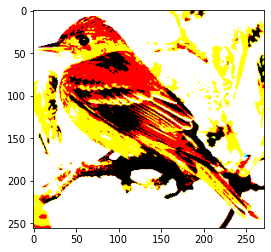

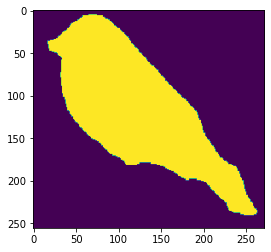

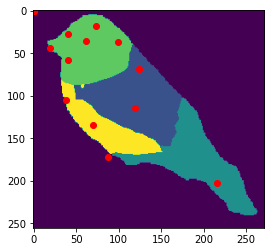

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5794/5794 [11:37<00:00,  8.31it/s]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [0 1 2 3] [0 1 2 3 4]
<All keys matched successfully>


 17%|████████████████████████████▍                                                                                                                                        | 1000/5794 [01:50<08:11,  9.75it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


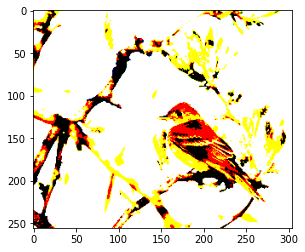

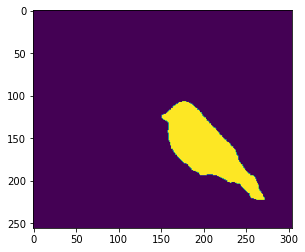

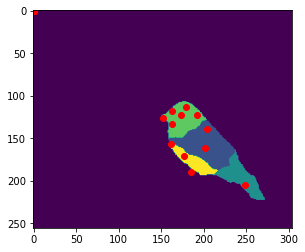

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5794/5794 [10:05<00:00,  9.56it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [0 1 2 3] [0 1 2 3 4]
FG-NMI1: 46.03 FG-ARI1: 21.03 Full-NMI: 43.52 Full-ARI: 19.58


In [3]:
is_scops = False
path = '../checkpoints/CUB/model_60000.pth'
nmi1, ari1 = eval_all(path=path, is_full=False, is_scops=is_scops, only_three=False, req_label=None,regress_landmark=False)
nmi2, ari2 = eval_all(path=path, is_full=True, is_scops=is_scops, only_three=False, req_label=None, regress_landmark=False)

print(f'FG-NMI1: {nmi1:2.2f} FG-ARI1: {ari1:2.2f} Full-NMI: {nmi2:2.2f} Full-ARI: {ari2:2.2f}')